**Description:** This notebook demonstrates the application of PIP-MYULA to the Bayesian matrix completion example.

In [1]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp
import torch

# Pyplot for plots.
import matplotlib.pyplot as plt 

Import algorithms

In [2]:
# Algorithms
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))  
sys.path.append(project_root)

from matrix_completion.example_1.algorithms_sparse import pip_myula_matrix_sparse

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.chdir(project_root)

2024-06-25 21:04:20.719017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 21:04:20.719049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 21:04:20.719759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 21:04:21.356719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


#### Example with checker board matrices for Xs and Theta

High-dimensional wide data

The data is created in the following way: generate 15 matrices, generate a tall matrix $\Theta$ that will be the common basis, compute true matrices. Finally, apply mask corresponding to the observed entries.

In [3]:
def checker_matrix_fix(size=(30, 2), a = (np.random.randint(6) -3), b = (np.random.randint(6) -3)):
    """Run alternating minimization on subsample of rank 2 matrix."""

    A = np.zeros(size)
    # Create rank 2 matrix with checkerboard pattern
    for i in range(0,size[0]):
        for j in range(0,size[1]):         
            if divmod(i, 2)[1]==0:
                A[i,j] += a 
            if divmod(i, 2)[1]==1:
                A[i,j] += -a
            if divmod(j, 2)[1]==0:
                A[i,j] += b
            if divmod(j, 2)[1]==1:
                A[i,j] += -b 
    #plot_decomposition(A)      
    return A

In [4]:
# Generate 15 matrices and concatenate them along the 3rd axis
num_matrices = 15
matrix_shape = (2, 100)
def generate_concatenated_matrices(num_matrices=num_matrices, matrix_shape=matrix_shape):
    #keys = jax.random.randint(key = jax.random.PRNGKey(10), shape=(num_matrices,), minval=0, maxval=200)
    matrices = []
    for k in range(num_matrices):
        # Generate a matrix using jax.random.normal
        matrix = checker_matrix_fix(matrix_shape)
        
        matrix_sparse = matrix + np.random.normal(scale=0.5, size = matrix_shape)

        matrices.append(matrix_sparse)
    concatenated_matrix = jnp.stack(matrices, axis=2)
    return concatenated_matrix

# Example usage
result_matrix = generate_concatenated_matrices()
print(result_matrix.shape)  # Sanity check: should be (matrix_shape, num_matrices)

(2, 100, 15)


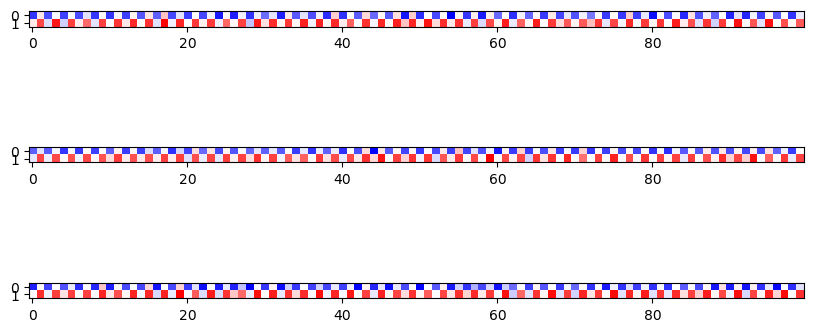

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5))
p = axs[0].imshow(result_matrix[:, :, 0], cmap='bwr')
axs[1].imshow(result_matrix[:, :, 5], cmap='bwr')
axs[2].imshow(result_matrix[:, :, 11], cmap='bwr')


In [6]:
def checker_matrix(size=(30, 2)):
    """Run alternating minimization on subsample of rank 2 matrix."""

    A = np.zeros(size)
    # Create rank 2 matrix with checkerboard pattern
    a = np.random.randint(6) -3
    b = np.random.randint(6) -3 
    for i in range(0,size[0]):
        for j in range(0,size[1]):         
            if divmod(i, 2)[1]==0:
                A[i,j] += a 
            if divmod(i, 2)[1]==1:
                A[i,j] += -a
            if divmod(j, 2)[1]==0:
                A[i,j] += b
            if divmod(j, 2)[1]==1:
                A[i,j] += -b 
    #plot_decomposition(A)      
    return A

theta_shape = (30, matrix_shape[0])
matrix_theta = checker_matrix(size=theta_shape) + np.random.normal(scale=1, size = theta_shape)

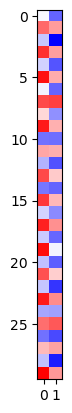

In [7]:
plt.imshow(matrix_theta, cmap='bwr')

In [8]:
# Obtain matrices Y multiplying X with the basis Theta
matrices_Y = jnp.tensordot(matrix_theta, result_matrix, axes=([1], [0]))

# Observation mask 
mask_observation = jax.random.randint(key = jax.random.PRNGKey(1), shape = matrices_Y.shape, minval = 0, maxval = 2)

observed_Y = jnp.where(mask_observation > 0, matrices_Y, 0)

dim_Y = np.sum(mask_observation)

Run algorithm

In [9]:
# Set approximation parameters:
h = 5e-2 # Step-size. 
K = 150  # Number of steps.
N = 30  # Number of particles.
gamma = 0.35 # Smoothing parameter

# Initialize parameter estimates:
a0 = np.array([1])  # Alpha.
#Theta0 = np.random.normal(0, 1, theta_shape)  # Basis matrix.
Theta0 = np.zeros(theta_shape)
###Theta0 = np.random.normal(0, 1, theta_shape)

# Initialize particle cloud by sampling prior:'
X0 = np.random.normal(0, 0.5, (matrix_shape[0], matrix_shape[1], num_matrices, N))  
mask_initial = jax.random.randint(key = jax.random.PRNGKey(50), shape=(matrix_shape[0], matrix_shape[1], num_matrices, N), minval=0, maxval=2)
X0_sparse = jnp.where(mask_initial == 0, X0, 0)
dim_Y = observed_Y.size
#dim_Y = np.sum(mask_observation)

# Run algorithms:
a, Thetas, X, rel_error, rel_error_missing, log_density_vec, rel_error_theta = pip_myula_matrix_sparse(observed_Y, mask_observation, h, K, a0, Theta0, X0_sparse, 
                                                                                      gamma, dim_Y, result_matrix, theta_true = matrix_theta)

100%|██████████| 150/150 [00:29<00:00,  5.06it/s]


In [ ]:
print(jnp.min(rel_error_missing), "Min square error of missing entries across the steps") 

0.021523286 Min relative error of missing entries across the steps


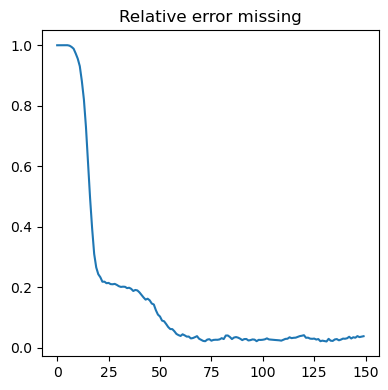

In [14]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# Plot 1
axs.plot(rel_error_missing)
axs.set_title('Relative error missing')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

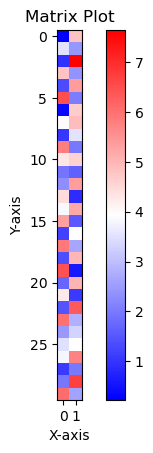

In [15]:
# Example matrix
matrixx = Thetas[-1]

# Plot the matrix
plt.imshow(np.abs(matrixx-matrix_theta), cmap='bwr')
plt.colorbar()  # Add color bar to show the scale
plt.title('Matrix Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

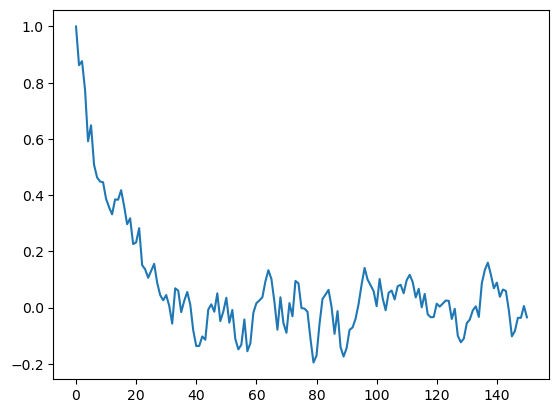

In [16]:
plt.plot(a)

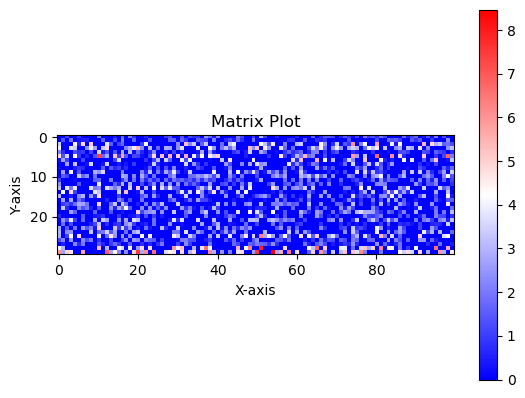

In [17]:
# Example matrix
i = 0
matrix_y = jnp.tensordot(Thetas[-1], X, axes=([1], [0]))[:,:,i,0]

# Plot the matrix
plt.imshow(np.abs((matrix_y-matrices_Y[:,:,i])*(1-mask_observation[:, :, i])), cmap='bwr')
plt.colorbar()  # Add color bar to show the scale
plt.title('Matrix Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

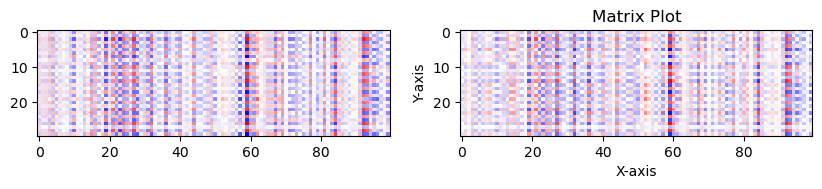

In [18]:
# Example matrix
i = 11
matrix_y = jnp.tensordot(Thetas[-1], X, axes=([1], [0]))[:,:,i,10]
matrix_z = jnp.tensordot(Thetas[-1], X, axes=([1], [0]))[:,:,3,10]

# Plot the matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
p0=axs[0].imshow(matrices_Y[:,:,i]-matrices_Y[:,:,3], cmap='bwr')
p1=axs[1].imshow(matrix_y-matrix_z, cmap='bwr')
#plt.colorbar()  # Add color bar to show the scale
#plt.colorbar(p1)  # Add color bar to show the scale
plt.title('Matrix Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()